In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
import xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
#load data
df = pd.read_csv("Car Sales Missing Data.csv")

print(df.head(20))

print(df.dtypes)

      Make Colour  Odometer (KM)  Doors      Price
0   Nissan  Black        10148.0    4.0  Rs1366850
1   Toyota  White        10217.0    4.0  Rs1144150
2   Toyota  White        10247.0    4.0  Rs1628300
3    Honda  White        10953.0    4.0   Rs831800
4   Nissan   Blue        10954.0    4.0  Rs1521950
5    Honda    Red        11035.0    4.0   Rs530100
6      BMW  Black        11049.0    3.0   Rs975000
7    Honda  White        11119.0    4.0  Rs1042250
8   Toyota  White        12141.0    4.0   Rs877800
9   Toyota    Red        13050.0    4.0   Rs453700
10   Honda  White        13116.0    4.0   Rs823200
11     NaN  Black        13266.0    4.0   Rs725100
12  Toyota  White        14497.0    4.0   Rs991900
13  Toyota   Blue        14645.0    4.0  Rs1066300
14   Honda  White        14700.0    4.0  Rs1348650
15   Honda    Red        16079.0    4.0   Rs497700
16     BMW  White        16274.0    5.0  Rs2622900
17   Honda  Black        16933.0    4.0   Rs608600
18  Nissan  Green        17119.

In [3]:
df['Price'] = df['Price'].apply(lambda x: int(str(x)[2:]) if not pd.isnull(x) else np.nan)

df.replace('NaN', np.nan)

print(df)
print(df.isna().sum())

       Make Colour  Odometer (KM)  Doors      Price
0    Nissan  Black        10148.0    4.0  1366850.0
1    Toyota  White        10217.0    4.0  1144150.0
2    Toyota  White        10247.0    4.0  1628300.0
3     Honda  White        10953.0    4.0   831800.0
4    Nissan   Blue        10954.0    4.0  1521950.0
..      ...    ...            ...    ...        ...
995  Toyota  White            NaN    4.0  1706650.0
996  Toyota  White            NaN    4.0  1767900.0
997     BMW  White            NaN    5.0  1906400.0
998  Toyota  White            NaN    4.0        NaN
999  Toyota  White            NaN    4.0        NaN

[1000 rows x 5 columns]
Make             49
Colour           50
Odometer (KM)    50
Doors            50
Price            50
dtype: int64


In [4]:
#EDA
#eda_df = df.loc[df.notna().any(axis=1).values]

print(df.dtypes)

float_cols = df.select_dtypes("float64").columns.tolist()
object_cols = df.select_dtypes("object").columns.tolist()

target = float_cols.pop()
object_cols.append(float_cols.pop())

Make              object
Colour            object
Odometer (KM)    float64
Doors            float64
Price            float64
dtype: object


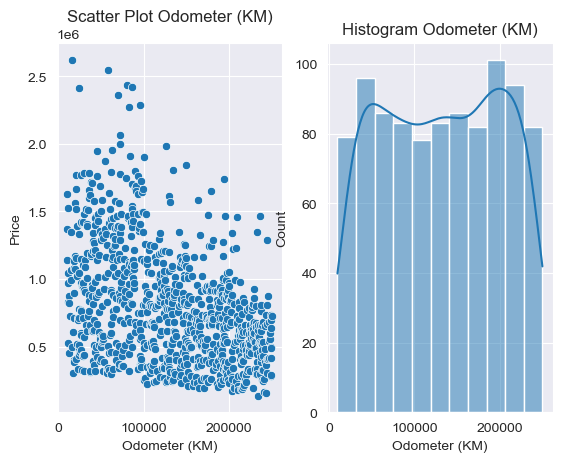

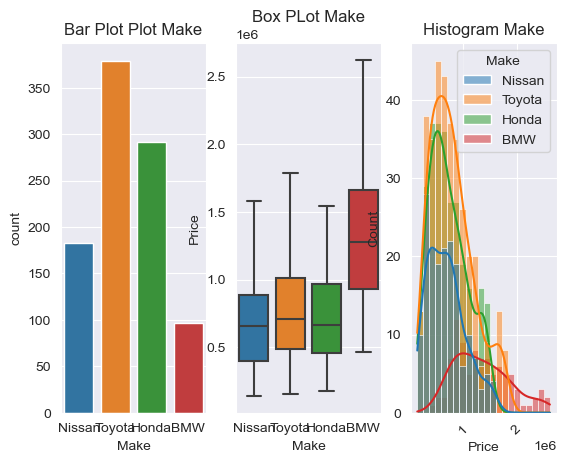

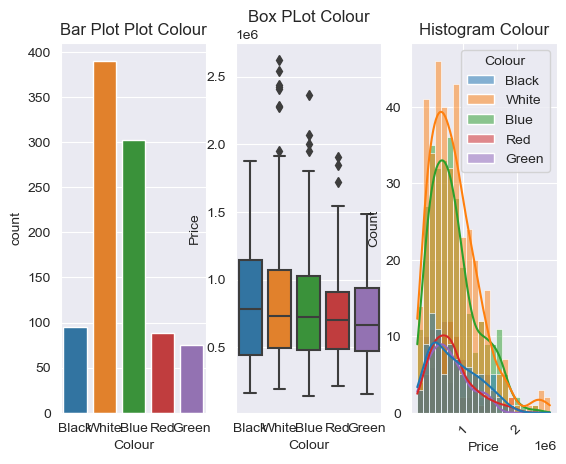

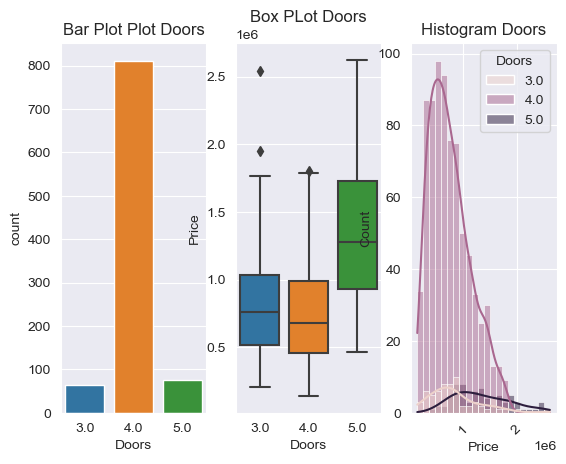

In [5]:
sns.set_style('darkgrid')

for col in float_cols:

    fig, ax = plt.subplots(1,2)
    
    sns.scatterplot(data=df, x=col, y=target, ax=ax[0])
    sns.histplot(data=df, x=col, kde=True, ax=ax[1])
    
    ax[0].set_title(f"Scatter Plot {col}")
    ax[1].set_title(f"Histogram {col}")
    
    
for col in object_cols:
    
    fig, ax = plt.subplots(1, 3)
    
    #plt.figure(figsize=(50, 50))
    
    sns.countplot(data=df, x=col, ax=ax[0])
    sns.boxplot(data=df, x=col, y=target,  ax=ax[1])
    sns.histplot(data=df, x=target, hue=col, ax=ax[2], kde=True)
    
    plt.xticks(rotation=45)
    
    ax[0].set_title(f"Bar Plot Plot {col}")
    ax[1].set_title(f"Box PLot {col}") 
    ax[2].set_title(f"Histogram {col}")   

#make = df["Make"].dropna()
#print(make.head(10))

#colour = df["Colour"].dropna()
#print(len(colour))

#odometer = df["Odometer /(KM/)"].dropna()
#print(len(odometer))

#doors = df["Doors"].dropna()
#print(len(doors))





In [6]:
class Score_Imputation_Method:
    def __init__(self):
        self.mape_scores = dict()

        
    def score(self, df, method):
        model = XGBRegressor()
        
        x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:, -1])

        model.fit(x_train, y_train)

        preds = model.predict(x_test)

        self.mape_scores[method] = mean_absolute_percentage_error(y_test, preds)
        
        print(self.mape_scores)

In [7]:
score_imputation = Score_Imputation_Method()


#Drop NA rows in target column
df = df[df['Price'].notna()]


one_hot_pipeline = Pipeline(steps=[('OneHotEncoder', OneHotEncoder())])

column_transformer = ColumnTransformer([("onehotencoder", one_hot_pipeline, object_cols)], remainder='passthrough', verbose_feature_names_out=False)

#1.) Drop NA Rows

df_drop_nas = df.copy()
df_drop_nas = df_drop_nas.dropna(axis=0)

df_drop_nas = pd.DataFrame(column_transformer.fit_transform(df_drop_nas), columns=column_transformer.get_feature_names_out())

score_imputation.score(df_drop_nas, "Drop NA")

{'Drop NA': 0.5155151683279368}


In [8]:
#2.) Simple Impute NAs

simple_imputer_df = df.copy()

cat_imputer = SimpleImputer(missing_values = np.nan, strategy ='most_frequent')
float_imputer = SimpleImputer(missing_values = np.nan, strategy ='mean')

#impute categorical features using most frequent 
for col in object_cols:
    simple_imputer_df[col] = cat_imputer.fit_transform(simple_imputer_df[col].values.reshape(-1, 1))

#impute continuous features using replacement with mean
for col in float_cols:
    simple_imputer_df[col] = float_imputer.fit_transform(simple_imputer_df[col].values.reshape(-1, 1))


#test on XGBoost Regressor
simple_imputer_df = pd.DataFrame(column_transformer.fit_transform(simple_imputer_df), columns=column_transformer.get_feature_names_out())

score_imputation.score(simple_imputer_df, "Simple Impute")

{'Drop NA': 0.5155151683279368, 'Simple Impute': 0.4980821834026967}


In [9]:
#3.)Hot Deck NAs
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import chi2

hot_deck_df = df.copy()

le = LabelEncoder()

label_encoded_categories = pd.DataFrame({"Make": le.fit_transform(df["Make"]), "Colour":le.fit_transform(df["Colour"]), "Doors":df["Doors"], "Odometer (KM)":df["Odometer (KM)"], "Price":df["Price"]})
label_encoded_categories = label_encoded_categories.dropna(axis=0)

print("f scores-------------")

#compute statstical feature selection for hot decking continues features
for col in object_cols:
    f_score = f_classif(label_encoded_categories[float_cols].values, label_encoded_categories[col])
    print(f"{col} f-score: {f_score[0]}")
    
print("chi2 scores-------------")

#compute statstical feature selection for hot decking categorical features
for col in object_cols:
    chi2_score = chi2(label_encoded_categories[object_cols].values, label_encoded_categories[col])
    print(f"{col} f-score: {chi2_score[0]}")
    
#make use doors or odometer
#colour use make
#odometer use make
#doors use make

#impute using hot decking


hot_deck_df = hot_deck_df.sort_values("Doors")
hot_deck_df["Make"].fillna(method="ffill", inplace=True)

hot_deck_df = hot_deck_df.sort_values("Make")
hot_deck_df[["Colour", "Doors", "Odometer (KM)"]].fillna(method="ffill", inplace=True)


hot_deck_df = pd.DataFrame(column_transformer.fit_transform(hot_deck_df), columns=column_transformer.get_feature_names_out())


#test on XGBoost Regressor
score_imputation.score(hot_deck_df, "Hot Deck")

f scores-------------
Make f-score: [1.99857772]
Colour f-score: [0.91116808]
Doors f-score: [0.14755618]
chi2 scores-------------
Make f-score: [5.43924162e+02 2.70335123e-01 8.16803852e+00]
Colour f-score: [2.06415895e+00 8.57596639e+02 1.85424189e-01]
Doors f-score: [131.63478153   1.40475935  31.67094142]


C:\Users\egrah\AppData\Local\Temp\ipykernel_21088\1417929458.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hot_deck_df[["Colour", "Doors", "Odometer (KM)"]].fillna(method="ffill", inplace=True)


{'Drop NA': 0.5155151683279368, 'Simple Impute': 0.4980821834026967, 'Hot Deck': 0.525627577774103}


In [10]:
#4.)Exlude NAs on Categorical features

df_dropna_column = df.copy()


df_dropna_column[["Make", "Colour"]] = df_dropna_column[["Make", "Colour"]].fillna("missing")
df_dropna_column["Doors"] = df_dropna_column["Doors"].fillna("missing")


df_dropna_column = pd.get_dummies(df_dropna_column)

df_dropna_column.drop(columns=["Make_missing", "Colour_missing", "Doors_missing"], inplace=True)

#drop missing odometer columns 
df_dropna_column.dropna(axis=0, inplace=True)

price_col = df_dropna_column.pop("Price")

df_dropna_column = df_dropna_column.join(price_col)


#test on XGBoost Regressor
score_imputation.score(df_dropna_column, "Drop NA Column")

{'Drop NA': 0.5155151683279368, 'Simple Impute': 0.4980821834026967, 'Hot Deck': 0.525627577774103, 'Drop NA Column': 0.48387338129778973}


In [11]:
#impute using ML techniques 
#5.) Iterative Impute using MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#replace categorical features with most frequent and use iterative imputer on continues features 
class CustomIterativeImputer:
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, df, strategy='mean'):
        
        simple_imputer = SimpleImputer(strategy=strategy)
        
        if self.cols==None:
            self.cols = list(df.columns)
            
        #impute categorical features
        for col in self.cols:
            if df[col].dtype == np.dtype("O"):
                most_frequent = df[col].value_counts().index[0]
                df[col].fillna(most_frequent, inplace=True)      

        df = pd.get_dummies(df)
        
        iterative_imputer = IterativeImputer()
        df = pd.DataFrame(iterative_imputer.fit_transform(df), columns = df.columns)
        
        return df
        

            
df_iterative_imputation = df.copy()

imputer = CustomIterativeImputer()

df_iterative_imputation = imputer.transform(df_iterative_imputation.iloc[:, :-1])


df_iterative_imputation["Price"] = df["Price"]


#drop rows with target values missing
df_iterative_imputation.dropna(axis=0, inplace=True)
df_iterative_imputation["Odometer (KM)"] = df_iterative_imputation["Odometer (KM)"].round()

#test on XGBoost Regressor
score_imputation.score(df_iterative_imputation, "Iterative Imputation")

{'Drop NA': 0.5155151683279368, 'Simple Impute': 0.4980821834026967, 'Hot Deck': 0.525627577774103, 'Drop NA Column': 0.48387338129778973, 'Iterative Imputation': 0.6579115698849232}


In [12]:
#6.) Knn
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer


df_KNN = df.copy()

scaler = MinMaxScaler()

#print(np.array(df_KNN["Odometer (KM)"]))
df_KNN["Odometer (KM)"] = scaler.fit_transform(np.array(df_KNN[["Odometer (KM)"]]))
df_KNN["Doors"] = scaler.fit_transform(np.array(df_KNN[["Doors"]]))

df_KNN = pd.get_dummies(df_KNN)


imputer = KNNImputer(n_neighbors=1)

price = df_KNN.pop("Price")

df_KNN = pd.DataFrame(imputer.fit_transform(df_KNN), columns = df_KNN.columns.tolist())

df_KNN["Price"] = price

df_KNN.dropna(axis=0, inplace=True)

#test on XGBoost Regressor
score_imputation.score(df_KNN, "KNN Imputation")

{'Drop NA': 0.5155151683279368, 'Simple Impute': 0.4980821834026967, 'Hot Deck': 0.525627577774103, 'Drop NA Column': 0.48387338129778973, 'Iterative Imputation': 0.6579115698849232, 'KNN Imputation': 0.6288626292325452}


In [27]:
#7.) Missingforest
from missforest.missforest import MissForest


df_miss_forest = df.copy()


mf = MissForest()

price = df_miss_forest.pop("Price")

df_miss_forest[["Make", "Colour"]] = df_miss_forest[["Make", "Colour"]].astype('category')

df_miss_forest = mf.fit_transform(df_miss_forest, categorical=["Make", "Colour"])

df_miss_forest["Price"] = price

df_miss_forest.dropna(axis=0, inplace=True)

df_miss_forest[["Make", "Colour"]] = df_miss_forest[["Make", "Colour"]].astype('object')


df_miss_forest = pd.get_dummies(df_miss_forest)

price = df_miss_forest.pop("Price")
df_miss_forest["price"] = price

#test on XGBoost Regressor
score_imputation.score(df_miss_forest, "Miss Forest Imputation")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 773, number of used features: 3
[LightGBM] [Info] Start training from score -1.619841
[LightGBM] [Info] Start training from score -0.926694
[LightGBM] [Info] Start training from score -1.190694
[LightGBM] [Info] Start training from score -2.280831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 773, number of used features: 3
[LightGBM] [Info] Start training from score 4.010349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 773, number of used features: 3
[LightGBM] [Info] Start training from score -2.293570
[LightGBM] [Info] Start training from score -0.904076
[LightGBM] [Info] Start training from score -1.124826
[LightGBM] [Info] Start training from score -2.445586
[LightGBM] [Info] Start training from score -2.491396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 773, number of used features: 3
[LightGBM] [Info] Start training from score -2.293570
[LightGBM] [Info] Start training from score -0.904076
[LightGBM] [Info] Start training from score -1.124826
[LightGBM] [Info] Start training from score -2.445586
[LightGBM] [Info] Start training from score -2.491396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 773, number of used features: 3
[LightGBM] [Info] Start training from score -2.293570
[LightGBM] [Info] Start training from score -0.904076
[LightGBM] [Info] Start training from score -1.124826
[LightGBM] [Info] Start training from score -2.445586
[LightGBM] [Info] Start training from score -2.491396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 773, number of used features: 3
[LightGBM] [Info] Start training from score -2.293570
[LightGBM] [Info] Start training from score -0.904076
[LightGBM] [Info] Start training from score -1.124826
[LightGBM] [Info] Start training from score -2.445586
[LightGBM] [Info] Start training from score -2.491396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

{'Drop NA': 0.5155151683279368, 'Simple Impute': 0.4980821834026967, 'Hot Deck': 0.525627577774103, 'Drop NA Column': 0.48387338129778973, 'Iterative Imputation': 0.6579115698849232, 'KNN Imputation': 0.6288626292325452, 'Miss Forest Imputation': 0.5549402105453245}


In [ ]:
#Drop NA and Simple Imputation worked best for this dataset 